# Лабораторная работа 4
*********
##  Кластеризация методом k-средних.

На этом занятии компьютерного практикума предстоит изучить кластеризацию методом k-средних и применить данный метод для сжатия изображения. Прежде чем приступить собственно к программированию, настоятельно рекомендуется ознакомиться с материалом лекций, а также с дополнительными материалами, имеющими отношение к задаче кластеризации методом k-средних.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import math

from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import scipy.io

В этом упражнении предстоит изучить как, собственно, сам метод k-средних, так и  применить его для сжатия изображений. В первой части Вы применяете метод k-средних для обработки 2-мерного набора данных, что способствует лучшему пониманию алгоритма. Далее, метод k-средних применяется для сжатия изображения, посредством уменьшения количества цветов и сохранения только тех цветов, которые встречаются в данном изображении чаще всего.

##  Часть 1: Нахождение ближайших центроидов

In [3]:
mat = scipy.io.loadmat('ex4data.mat')
X = mat['X']

In [4]:
def plot_data(X: np.ndarray) -> None:
    plt.figure(figsize=(17,13))
    plt.scatter(X[:,0], X[:,1], s = 200, color='green',  marker='o',  alpha=0.5)
    plt.yticks(size=15)
    plt.xticks(size=15)
    plt.title('Визуализация данных', fontsize=20)

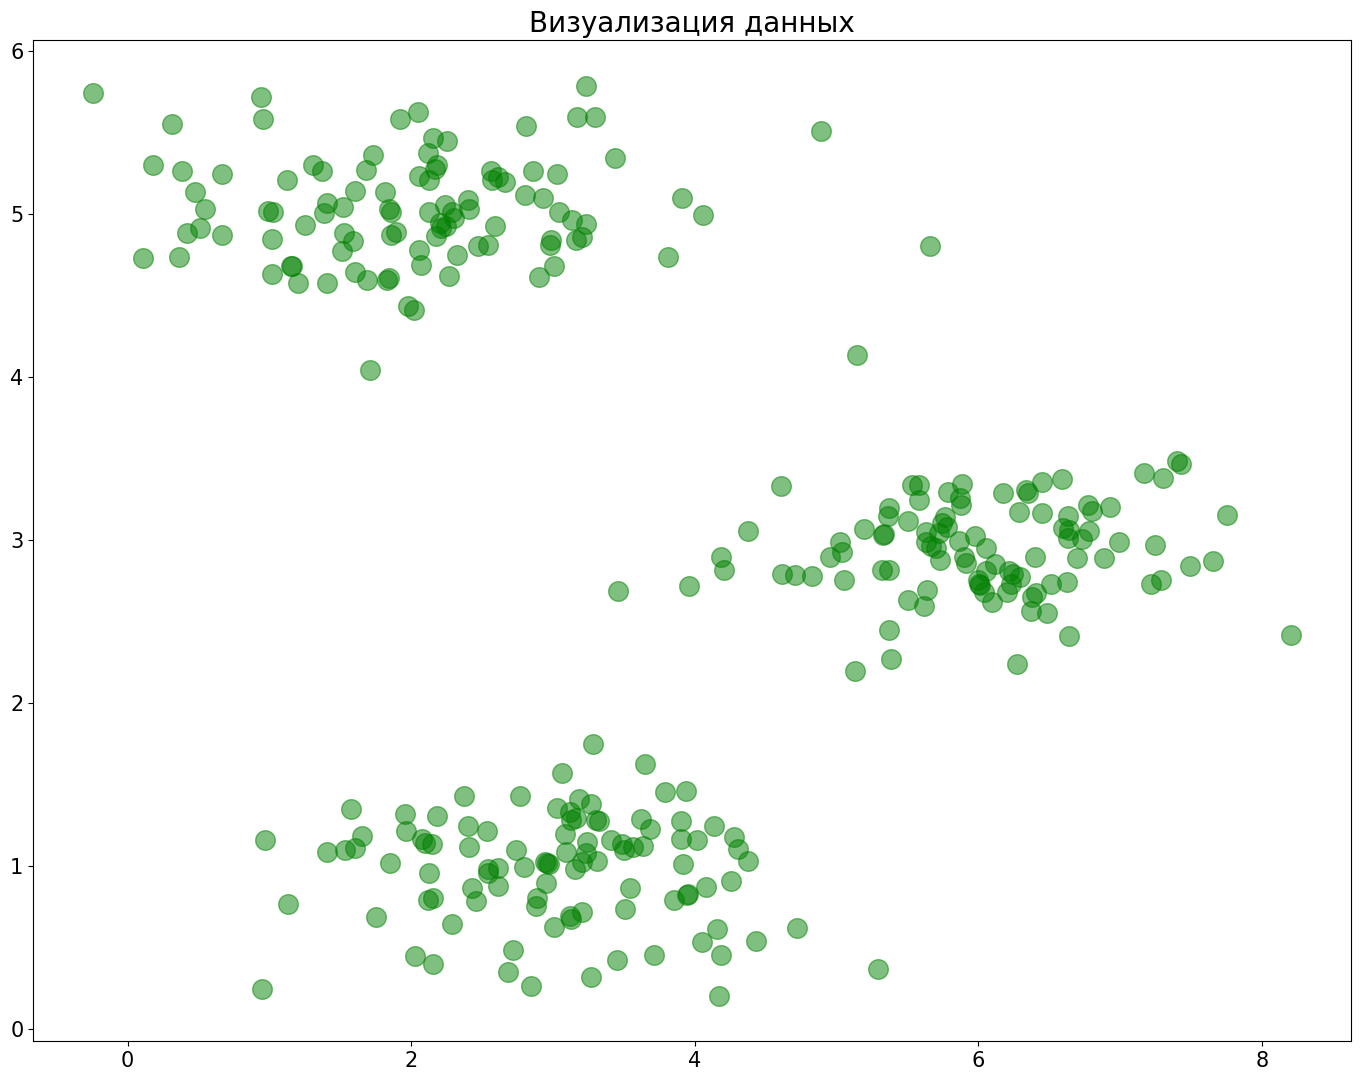

In [5]:
plot_data(X)

In [6]:
def get_distance_between_points(
    a: np.ndarray,
    b: np.ndarray
    ) -> float:
    return np.sum(np.square(a - b)) ** 0.5

In [7]:
def find_closest_centroids(X: np.ndarray,
                           centroids: np.ndarray
                           ) -> np.ndarray:
    '''
    Осуществите полный перебор набора данных, для каждого элемента
    набора данных найдите соответствующий ему ближайший центр,
    сохраните индекс в одномерном массиве idx.
    А именно, idx(i) должен содержать индекс
    ближайшего центра для произвольного примера i. Таким образом,
    диапазон значений в заполняемом массиве должен быть от 0 до K - 1.
    '''
    idx = np.zeros((X.shape[0], 1), dtype=int)
    m = X.shape[0]
    
    for i in range(m):
        point = X[i]
        distances = np.array([get_distance_between_points(point, centroid) for centroid in centroids])
        idx[i] = distances.argmin()

    return idx

In [8]:
# 3 центроида
K = 3
initial_centroids = np.array( [[3, 3], [6, 2], [8, 5]] )

# Нахождение ближайших центроидов для выбранных элементов
idx = find_closest_centroids(X, initial_centroids)

In [9]:
print('Ближайшие центры для 3-х первых примеров:\n')
print(*idx[:3])

Ближайшие центры для 3-х первых примеров:

[0] [2] [1]


Ожидаемый ответ:

`[0] [2] [1]`

##  Часть2: Вычисление средних

Расчет средних значений центров

In [10]:
def compute_centroids(X: np.ndarray,
                      idx: np.ndarray,
                      K: int
                      ) -> np.ndarray:
    '''
    compute_centroids возвращает новые значения центров, формируемые в процессе
    итерационного уточнения положения среднего.
    Уточнение сводится к перегруппировке примеров (точек) к ближайшим центрам
    и последующему перерасчету местоположения центров.
    centroids = compute_centroids(X, idx, K) возвращает новые центры.
    В качестве входных данных выступает набор (матрица) X,
    каждая строка которого (которой) представляет собой отдельный пример, a
    вектор idx = m x 1 определяет индексы центров i-го примера
    (К - количество центров). Возвращаемой переменной является матрица
    центров, в которой каждая строка представляет собой конечное среднее центров.

    Указание:     Обрабатывайте каждый центр и вычисляйте среднее значение
                    всех точек (примеров), которые ему соответствуют.
                    Конкретнее, вектор-строка центров centroids(i, :)
                    должен содержать среднее значение всех примеров,
                    соответствующих центроиду i.
    '''
    _, n = X.shape
    centroids = np.zeros((K, n))
    df = pd.DataFrame(X)
        
    for i in range(K):
        points = df[idx == i]
        centroids[i] = points.mean()
    
    return centroids

In [11]:
#  Вычислите средние значения центров, основываясь на центроидах, найденных
#  в предыдущей части.
centroids = compute_centroids(X, idx, K);

In [12]:
print('Перерасчет местоположения центров после нахождения ближайших центров: \n')
print('  ',centroids[0])
print('  ',centroids[1])
print('  ',centroids[2])

Перерасчет местоположения центров после нахождения ближайших центров: 

   [2.42830111 3.15792418]
   [5.81350331 2.63365645]
   [7.11938687 3.6166844 ]


Ожидаемый ответ:
```
[ 2.428301 3.157924 ]
[ 5.813503 2.633656 ]
[ 7.119387 3.616684 ]
```

##  Часть 3: Кластеризация на основе метода k-средних

Выполнение процедуры кластеризации методом k-средних на тестовом наборе данных.

In [13]:
def draw_line(p1: np.ndarray,
              p2: np.ndarray
              ) -> None:
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], linewidth = 2, color='black')

In [14]:
def hsv(n: int = 63) -> np.ndarray:
    from matplotlib import colors
    return colors.hsv_to_rgb(np.column_stack([np.linspace(0, 1, n+1), np.ones(((n+1), 2))]))

In [15]:
def plot_data_points(X: np.ndarray,
                     idx: np.ndarray,
                     K: int
                     ) -> None:
    palette = hsv(K)
    colors = np.array([palette[int(i)] for i in idx])

    # Plot the data
    plt.scatter(X[:,0], X[:,1], s=200, facecolors='none', edgecolors=colors)


In [16]:
def plot_progress_k_means(X: np.ndarray,
                          centroids: np.ndarray,
                          previous: np.ndarray,
                          idx: np.ndarray,
                          K: int,
                          i: int
                          ) -> None:
    plot_data_points(X, idx, K)
    plt.scatter(centroids[:,0], centroids[:,1], marker='x', s=500, c='k', linewidth=5)
    for j in range(centroids.shape[0]):
        draw_line(centroids[j, :], previous[j, :])

    plt.title(f'Iteration number {i + 1} \n', fontsize=20)

In [17]:
import sys


def run_k_means(X: np.ndarray,
                initial_centroids: np.ndarray,
                max_iters: int
                ) -> tuple[np.ndarray, np.ndarray]:
    m, _ = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids
    idx = np.zeros((m, 1))

    plt.figure(figsize=(17,13))
    for i in range(max_iters):
        sys.stdout.write(f'\rK-Means iteration {i + 1}/{max_iters}...')
        sys.stdout.flush()

        idx = find_closest_centroids(X, centroids)

        plot_progress_k_means(X, centroids, previous_centroids, idx, K, i)
        previous_centroids = centroids

        centroids = compute_centroids(X, idx, K)

    return centroids, idx

K-Means iteration 10/10...
K-Means Done.



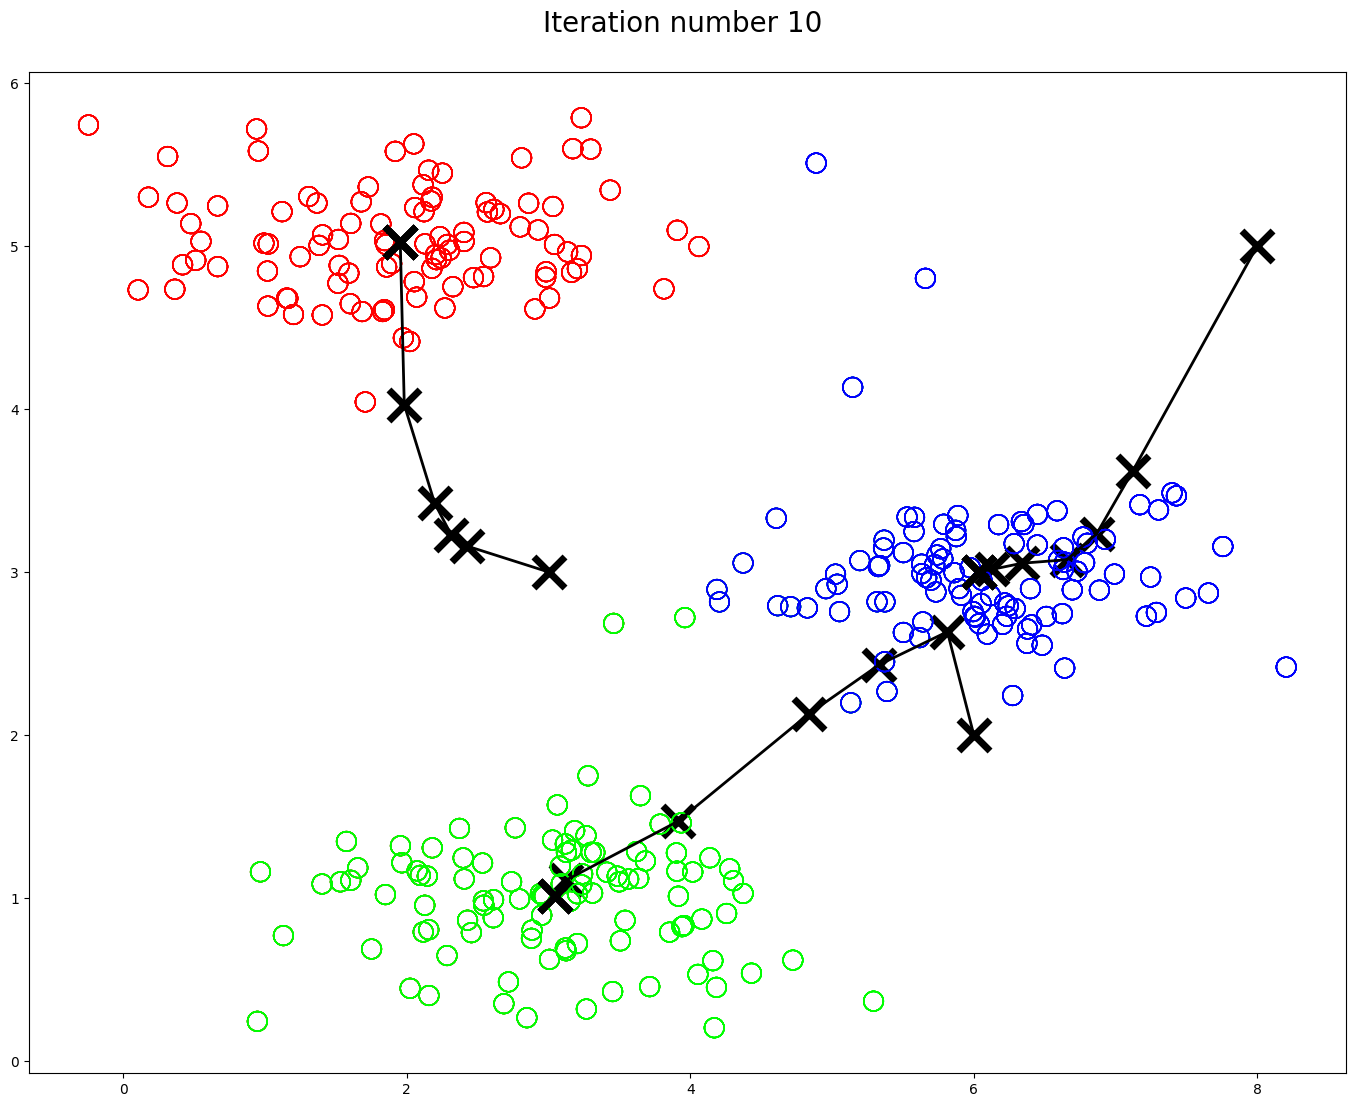

In [18]:
# Начальные установки для реализации алгоритма
K = 3
max_iters = 10
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

centroids, idx = run_k_means(X, initial_centroids, max_iters)
print('\nK-Means Done.\n')

In [19]:
from sklearn.cluster import KMeans

In [20]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(X)

KMeans(n_clusters=3, random_state=42)

In [21]:
model.labels_

array([2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2], d

In [22]:
model.cluster_centers_

array([[3.04367119, 1.01541041],
       [6.03366736, 3.00052511],
       [1.95399466, 5.02557006]])

Ожидаемый ответ (порядок строк может отличаться):
```
array([[3.04367119, 1.01541041],
       [1.95399466, 5.02557006],
       [6.03366736, 3.00052511]])
```

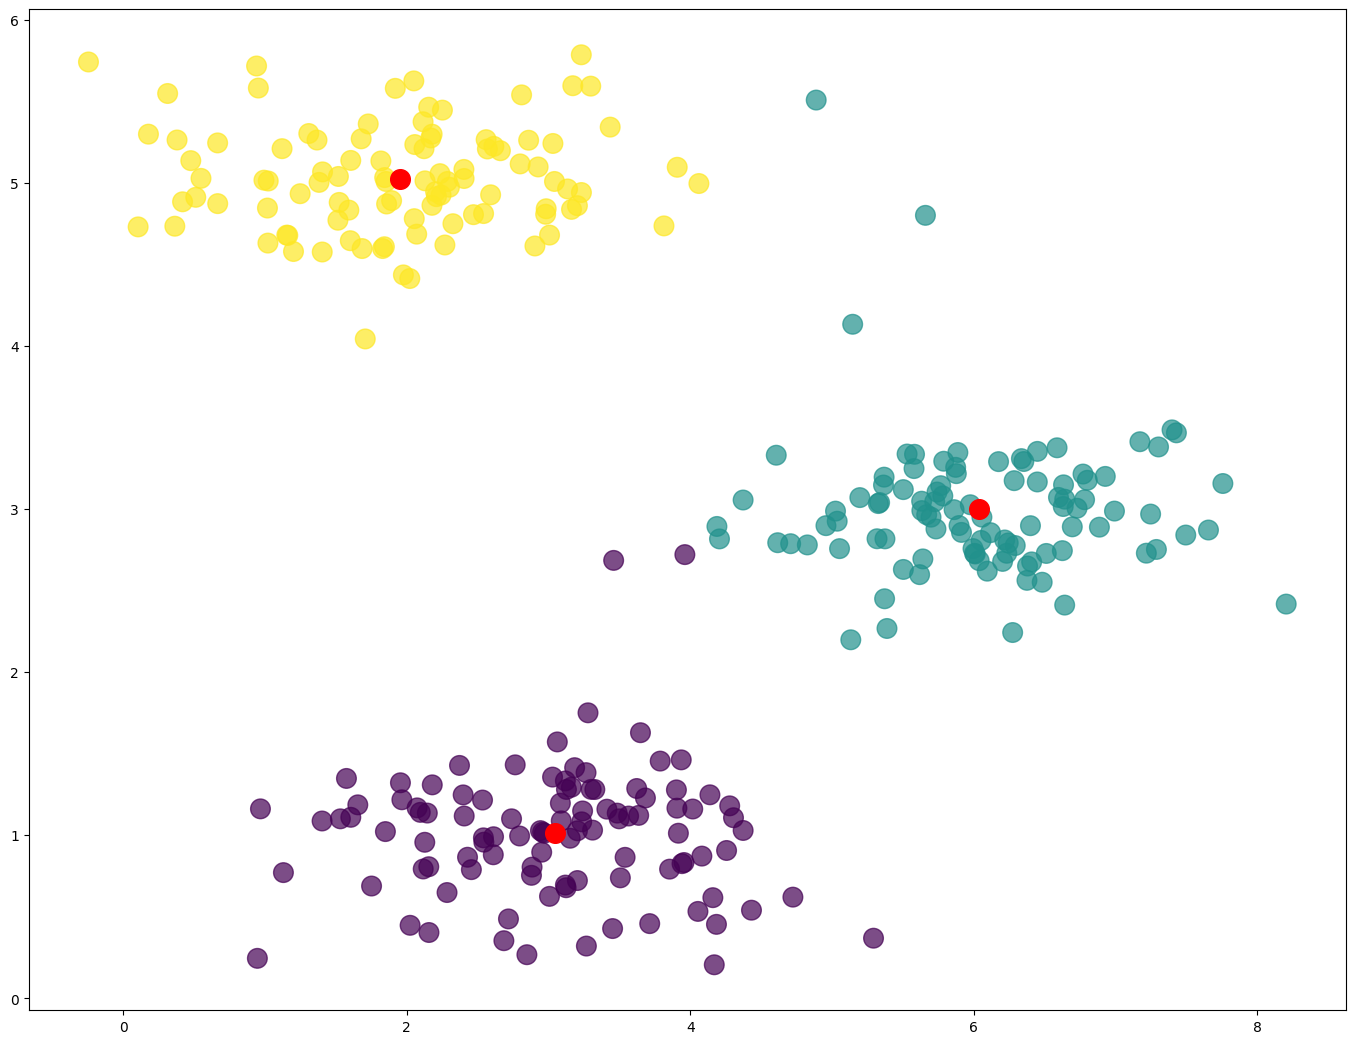

In [23]:
plt.figure(figsize=(17,13))
plt.scatter(X[:,0], X[:,1], s=200,  marker ='o',  alpha=0.7, c=model.labels_)
plt.scatter(model.cluster_centers_[:,0] ,model.cluster_centers_[:,1], s = 200, color='red',  marker='o')
plt.show()

In [24]:
def init_centroids_for_k_means(X: np.ndarray, K: int):
  '''
  Указание: Установите центры случайным образом из набора Х.
  '''
  temp = X.copy()
  np.random.shuffle(temp)
  return temp[:K]


 [[7.30278708 3.38015979]
 [4.72372078 0.62044136]
 [2.45575934 0.78904654]] 

K-Means iteration 10/10...
 [[3.03084301 5.24057582]
 [6.69451358 2.89056083]
 [3.30063655 1.28107588]] 

K-Means iteration 10/10...
 [[3.1189017  0.69438336]
 [0.66582785 5.24399257]
 [2.92658295 5.09667923]] 

K-Means iteration 8/10...

K-Means iteration 10/10...
 [[2.84734459 0.26759253]
 [3.11876541 1.33285459]
 [2.17893568 5.29758701]] 

K-Means iteration 10/10...
 [[5.36708111 3.19502552]
 [2.24185052 4.9244617 ]
 [3.90206657 1.27778751]] 

K-Means iteration 10/10...

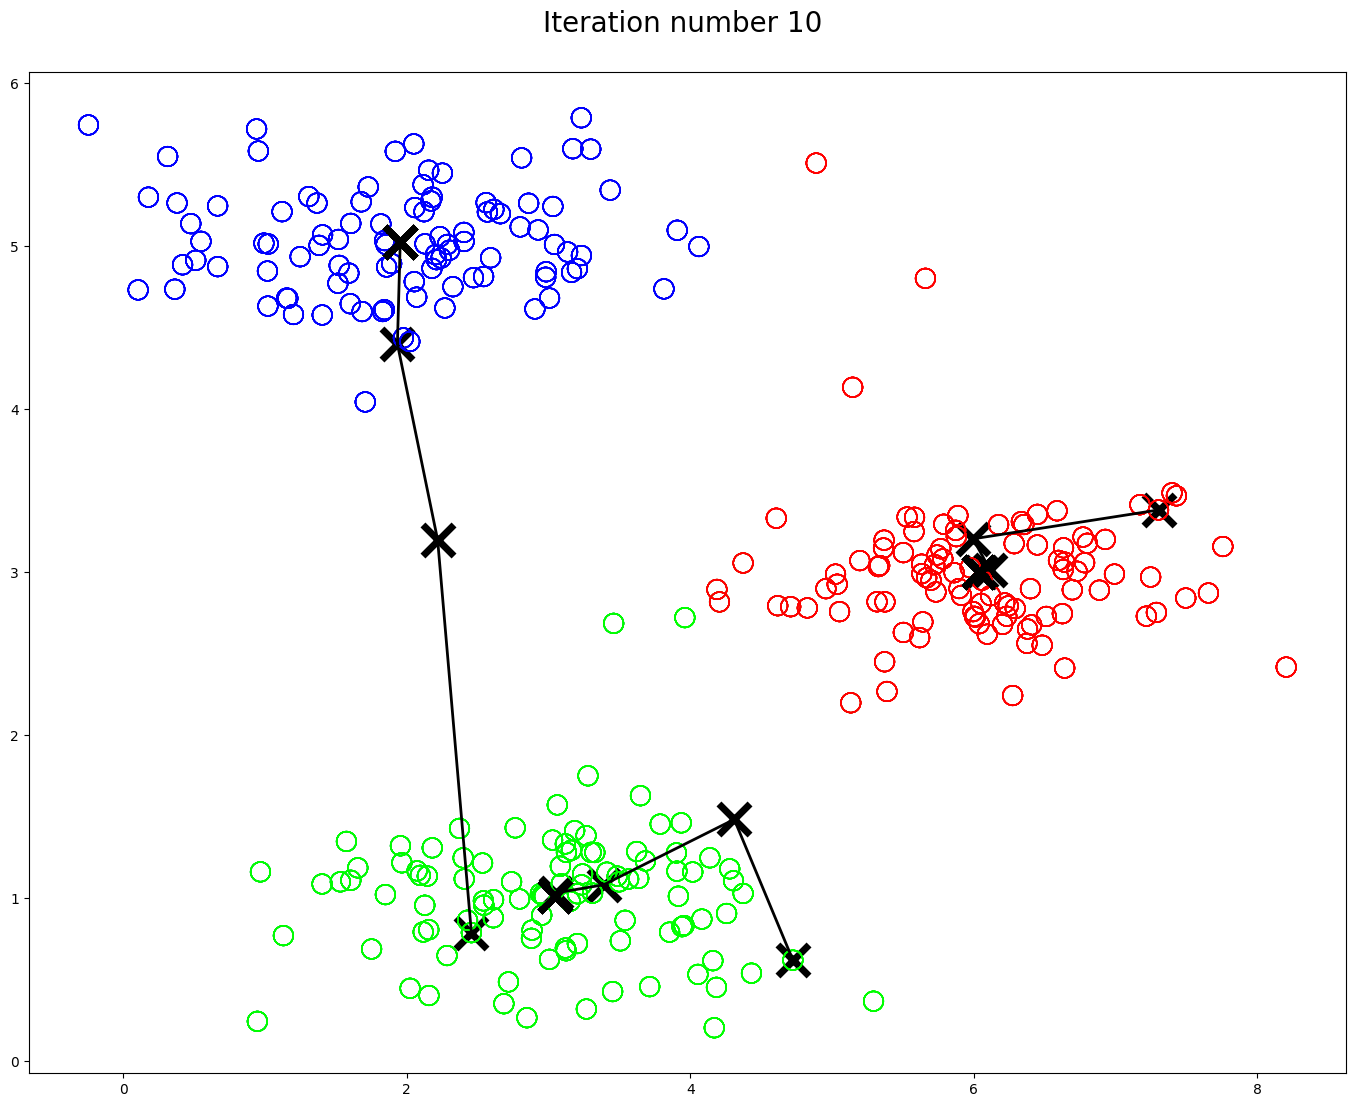

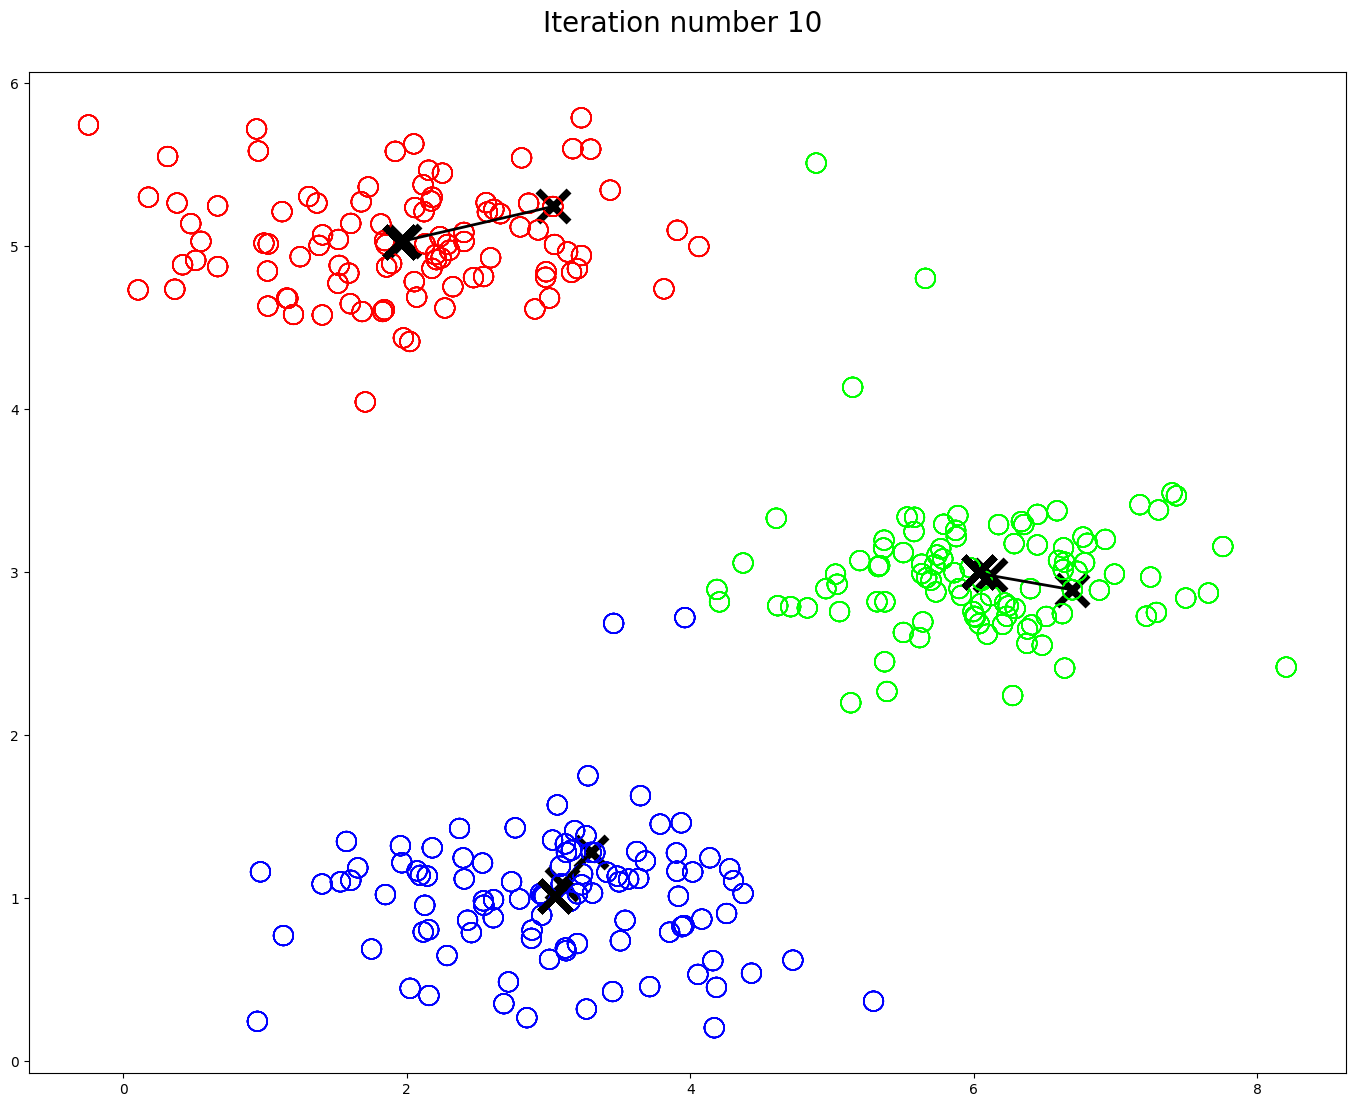

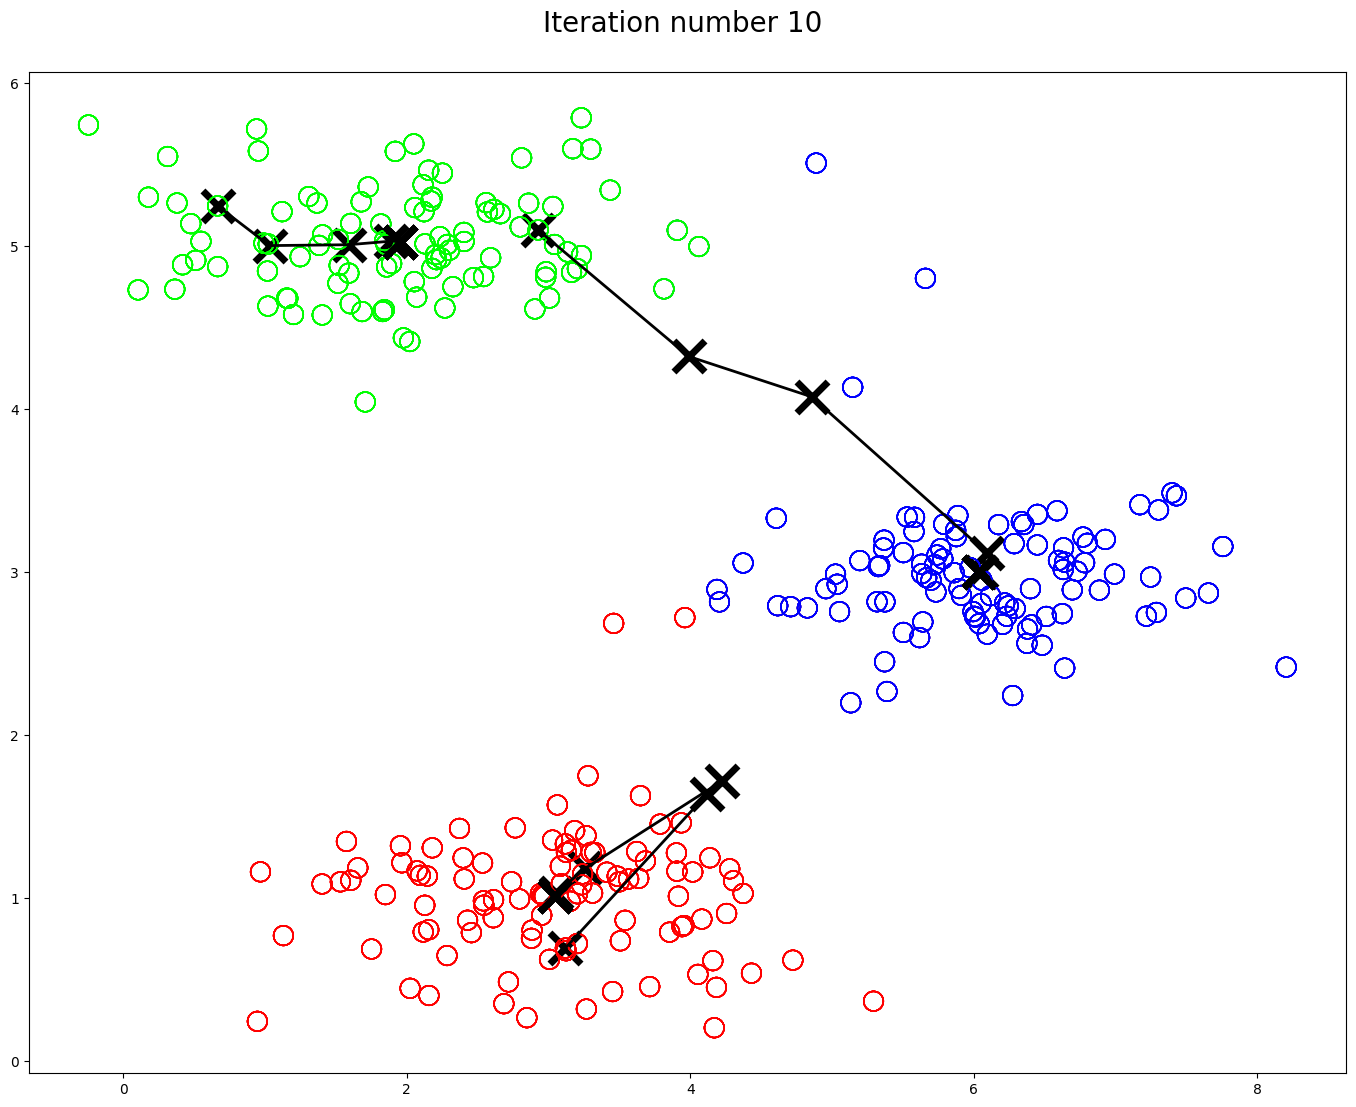

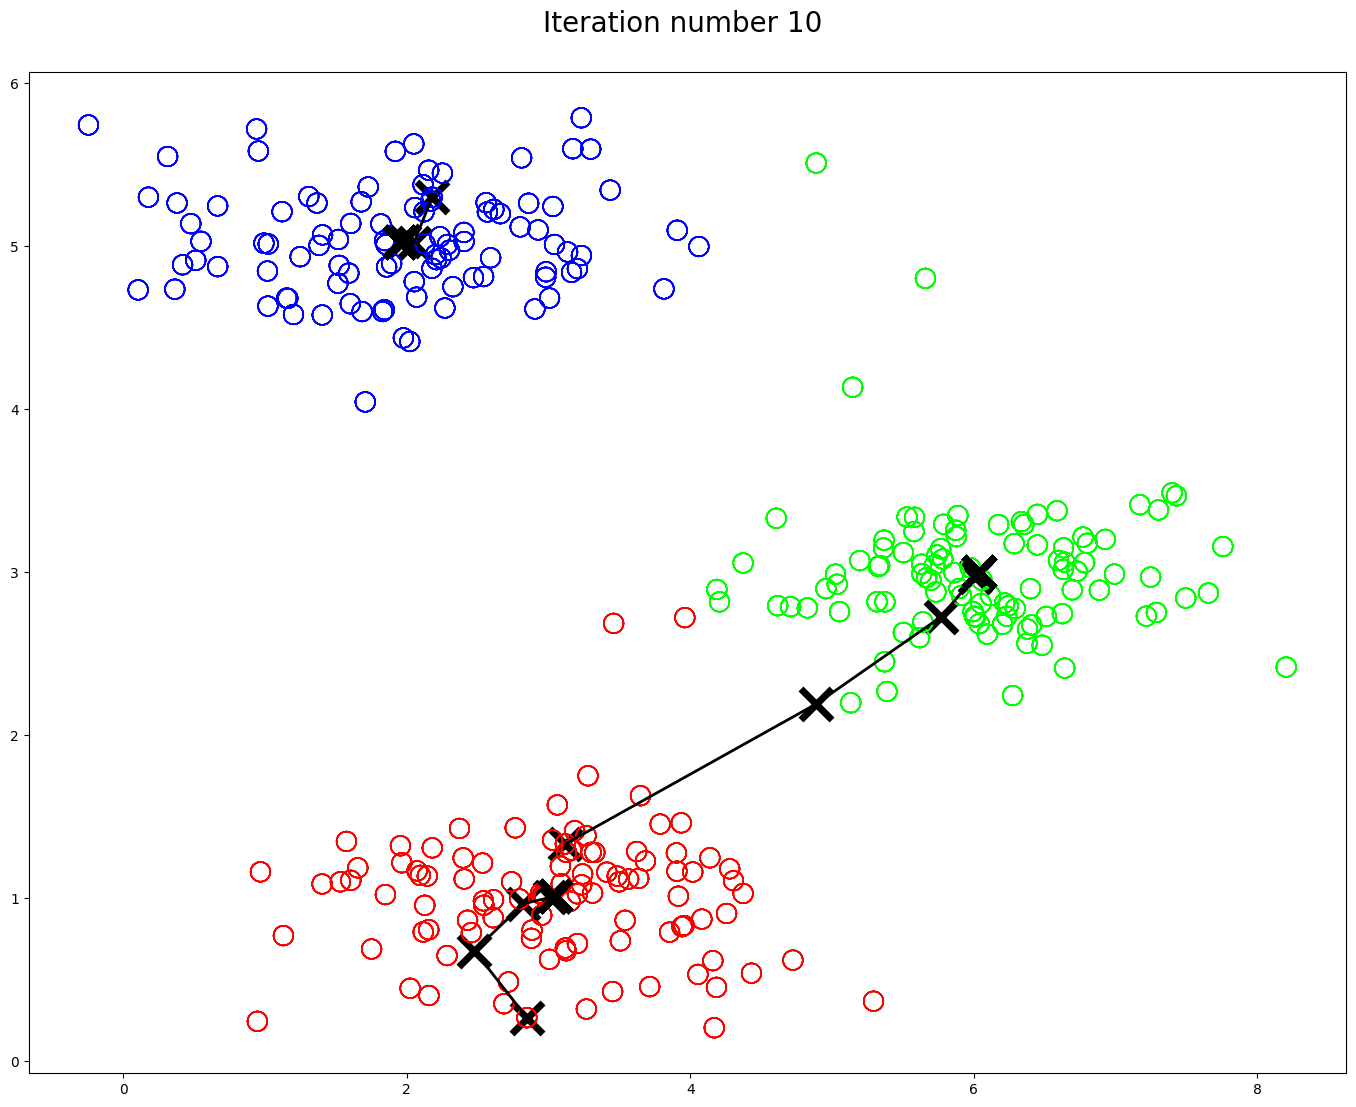

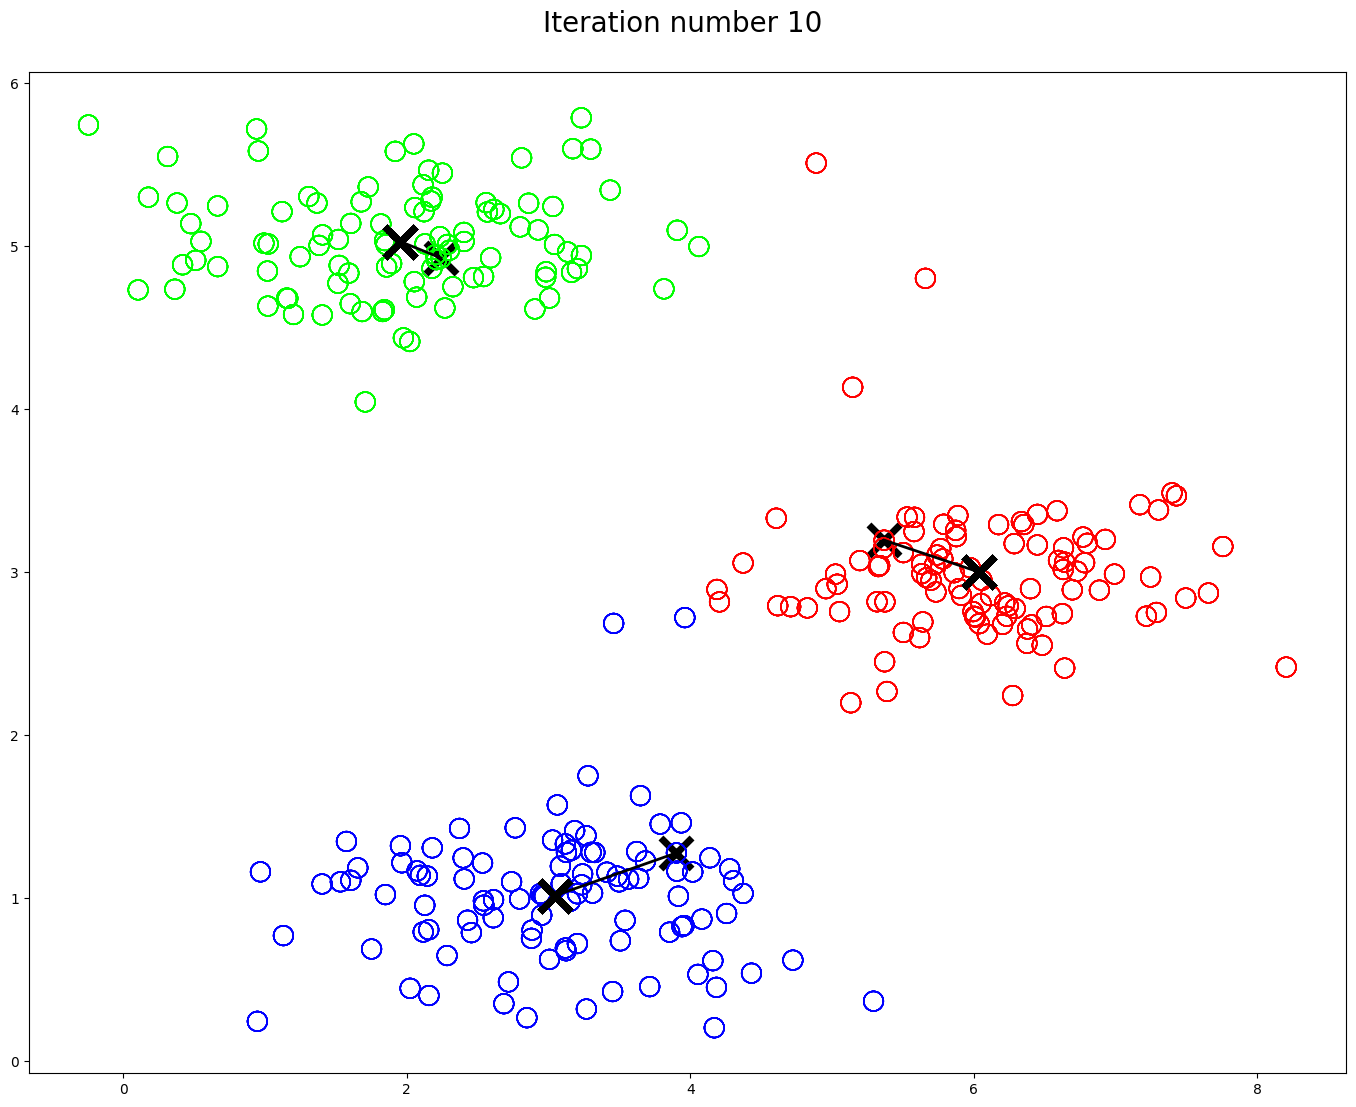

In [25]:
for i in range(5):
    centroids = init_centroids_for_k_means(X, 3)
    print('\n', centroids, '\n')
    centroids, idx = run_k_means(X, centroids, max_iters)

## Часть 4-5: "K-means" кластеризация элементов изображения и его сжатие
  Терминология: пиксел (англ. pixel = picture element) обозначает элемент изображения ("элиз"). В данном упражнении, следует применить процедуру кластеризации методом k-средних для сжатия изображения. Для того, чтобы сделать это, "k-means" кластеризация производится в цветовом пространстве исходного изображения, а затем производится отображение на ближайшие центроиды в трансформированном цветовом пространстве.

In [26]:
def compress_image(filepath: str,
                   centroids_count: int,
                   max_iters: int = 50
                   ) -> None:
    if not filepath.endswith('.mat'):
        raise ValueError("Only .mat pictures are supported")
    
    import scipy.io
    
    data = scipy.io.loadmat(filepath)
    original = data[list(data.keys())[-1]]
    original = original / 255
    
    X = original.copy()
    img_size = X.shape # Размер изображения

    # Переопределение RGB изображения в матрицу Nx3, где N = количество элизов.
    # Таким образом, каждая строка содержит сейчас значения компонент красного, зеленого и синего цветов
    # В результате таких трансформаций, образована матрица X, которая будет использована в k-means.
    X = X.reshape(img_size[0] * img_size[1], 3, order='F')

    # При  моделировании следует производить случайную начальную инициализацию центроидов.
    # Необходимо запрограммировать init_centroids_for_k_means.m перед обработкой
    initial_centroids = init_centroids_for_k_means(X, centroids_count)

    # Моделирование алгоритма
    centroids, _ = run_k_means(X, initial_centroids, max_iters)
    
    print('\nApplying K-Means to compress an image.\n')

    # Нахождение ближайших значений в кластере
    idx = find_closest_centroids(X, centroids)

    # Представление изображения X в терминах индексов в idx.
    # Восстановление изображения производится посредством отображения каждой точки изображения
    # (заданной посредством индексов в idx) на значения центроидов
    compressed = centroids[idx,:]

    # Преобразование формата изображения
    compressed = (compressed.reshape(img_size[0], img_size[1], 3, order='F') * 255).astype(int)

    # Отображение исходного изображения
    plt.figure(figsize=(15,15))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title('Original \n', fontsize=20)

    # Отображение сжатого изображения
    plt.subplot(1, 2, 2)
    plt.imshow(compressed)
    plt.title(f'Compressed, with {centroids_count} colors.\n', fontsize=20)
    plt.show(block=False)

    

K-Means iteration 1/50...

K-Means iteration 50/50...
Applying K-Means to compress an image.



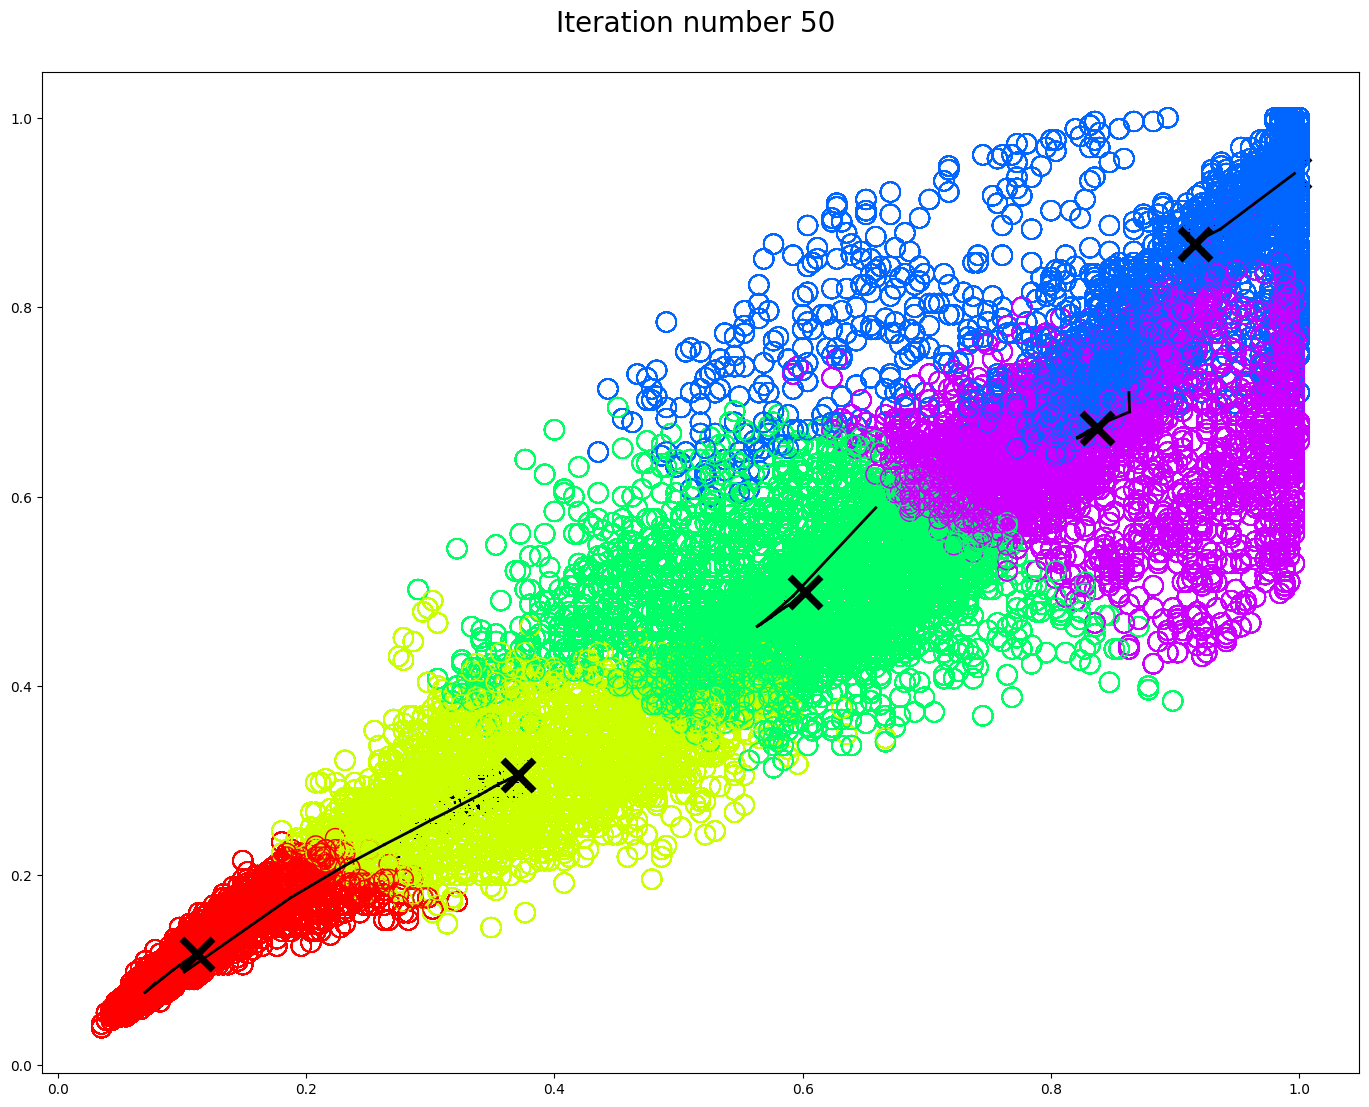

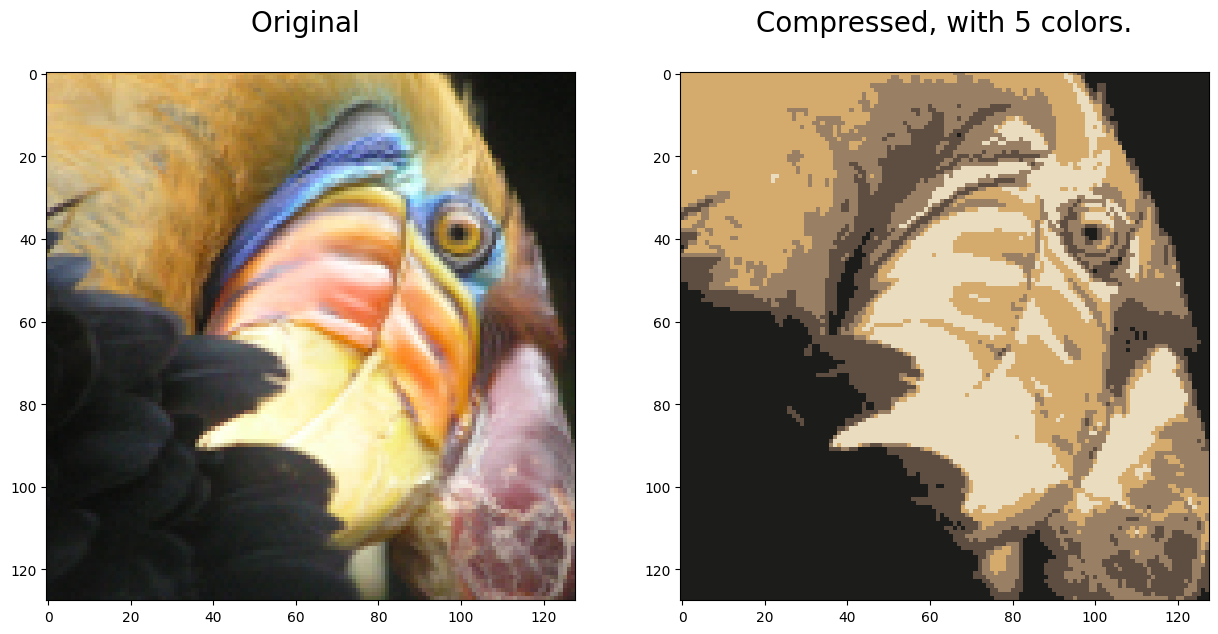

In [27]:
compress_image('bird_small.mat', 5)

K-Means iteration 50/50...
Applying K-Means to compress an image.



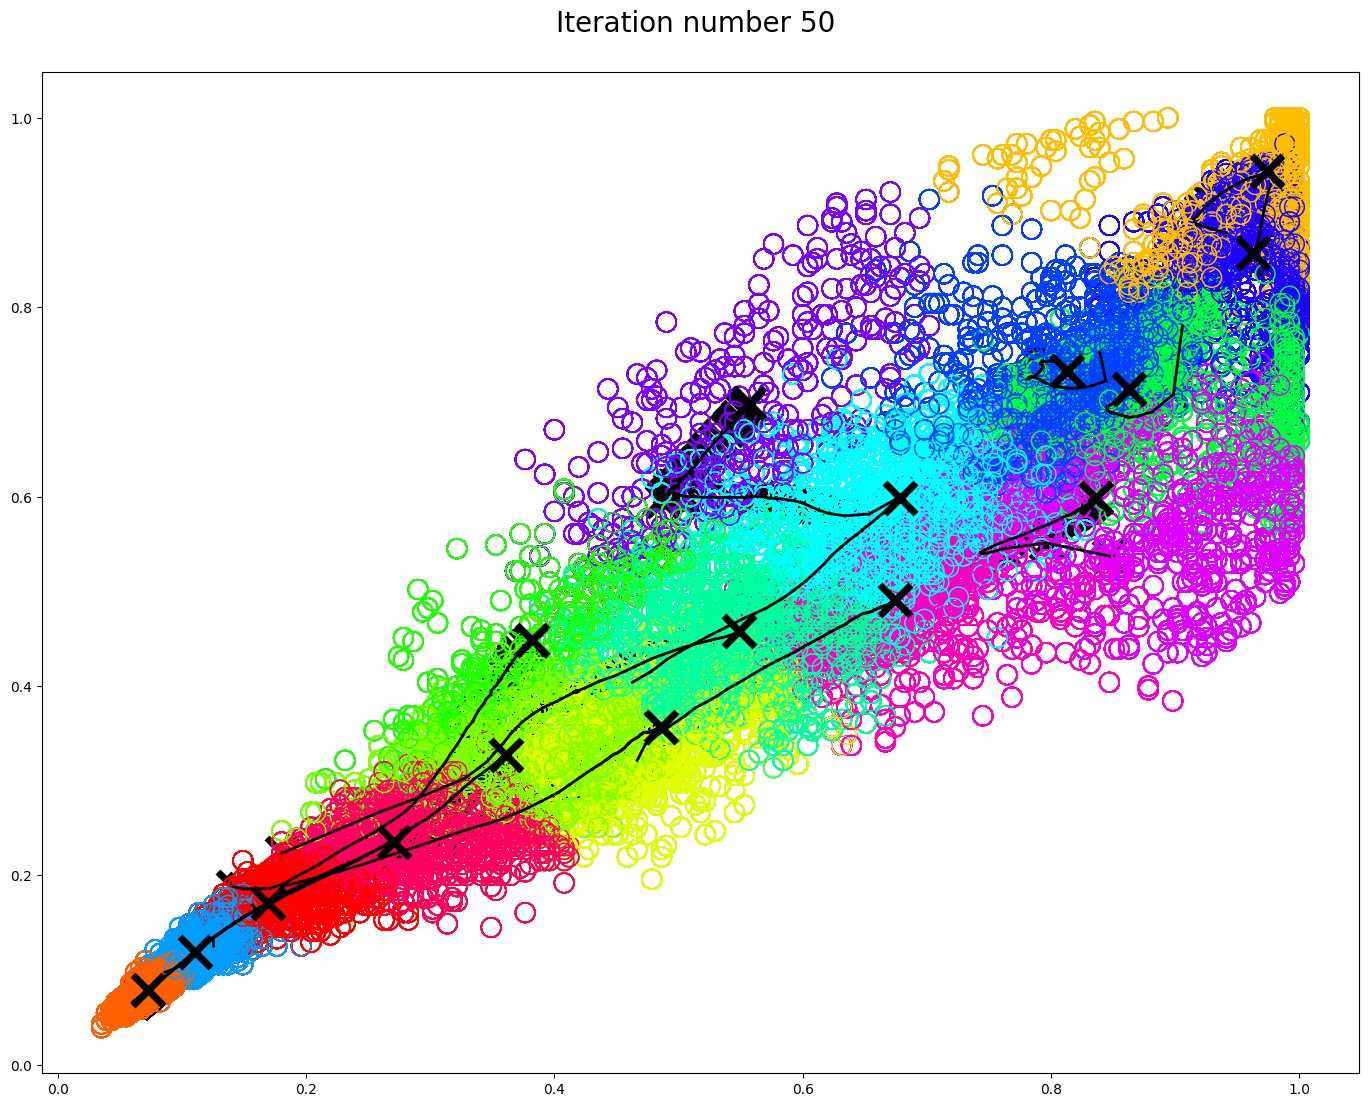

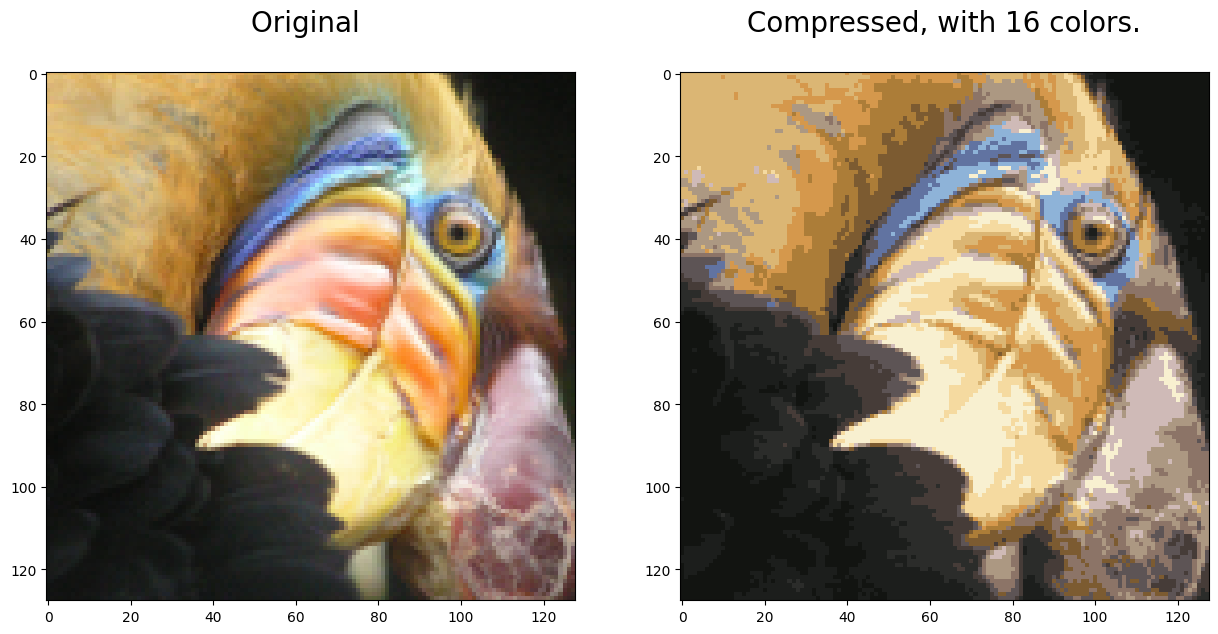

In [28]:
compress_image('bird_small.mat', 16)

K-Means iteration 50/50...
Applying K-Means to compress an image.



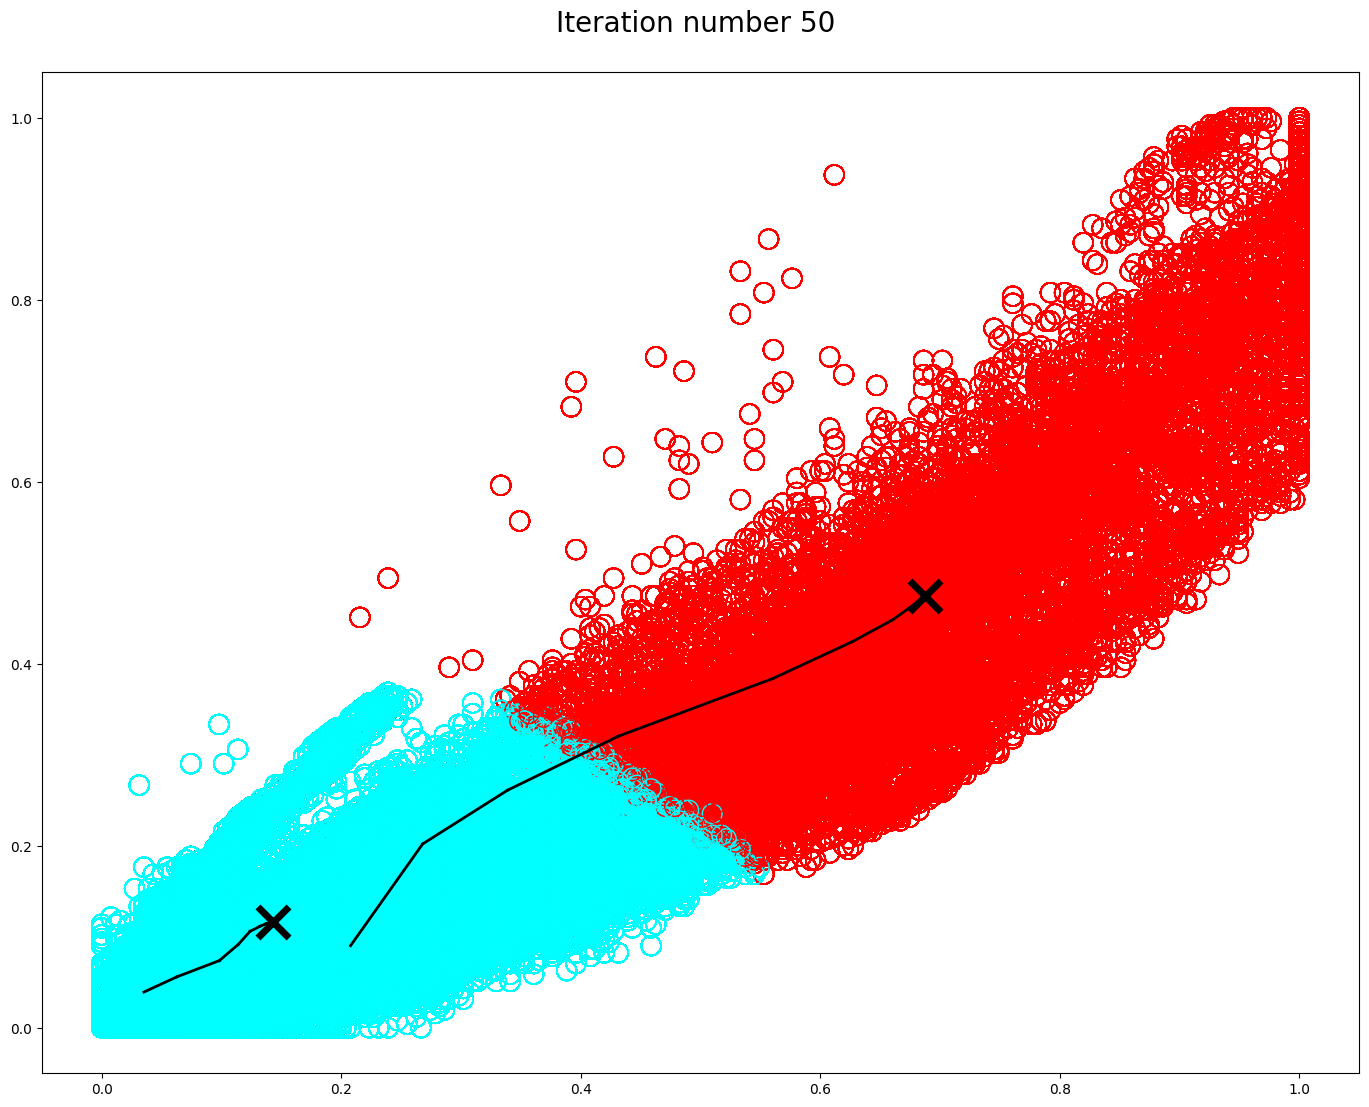

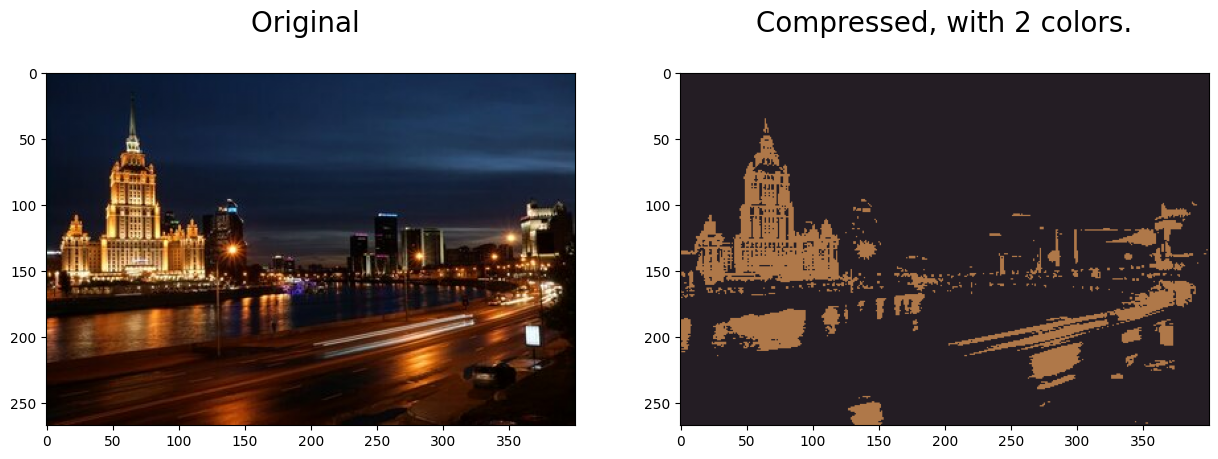

In [31]:
compress_image('moscow.mat', 2)

K-Means iteration 50/50...
Applying K-Means to compress an image.



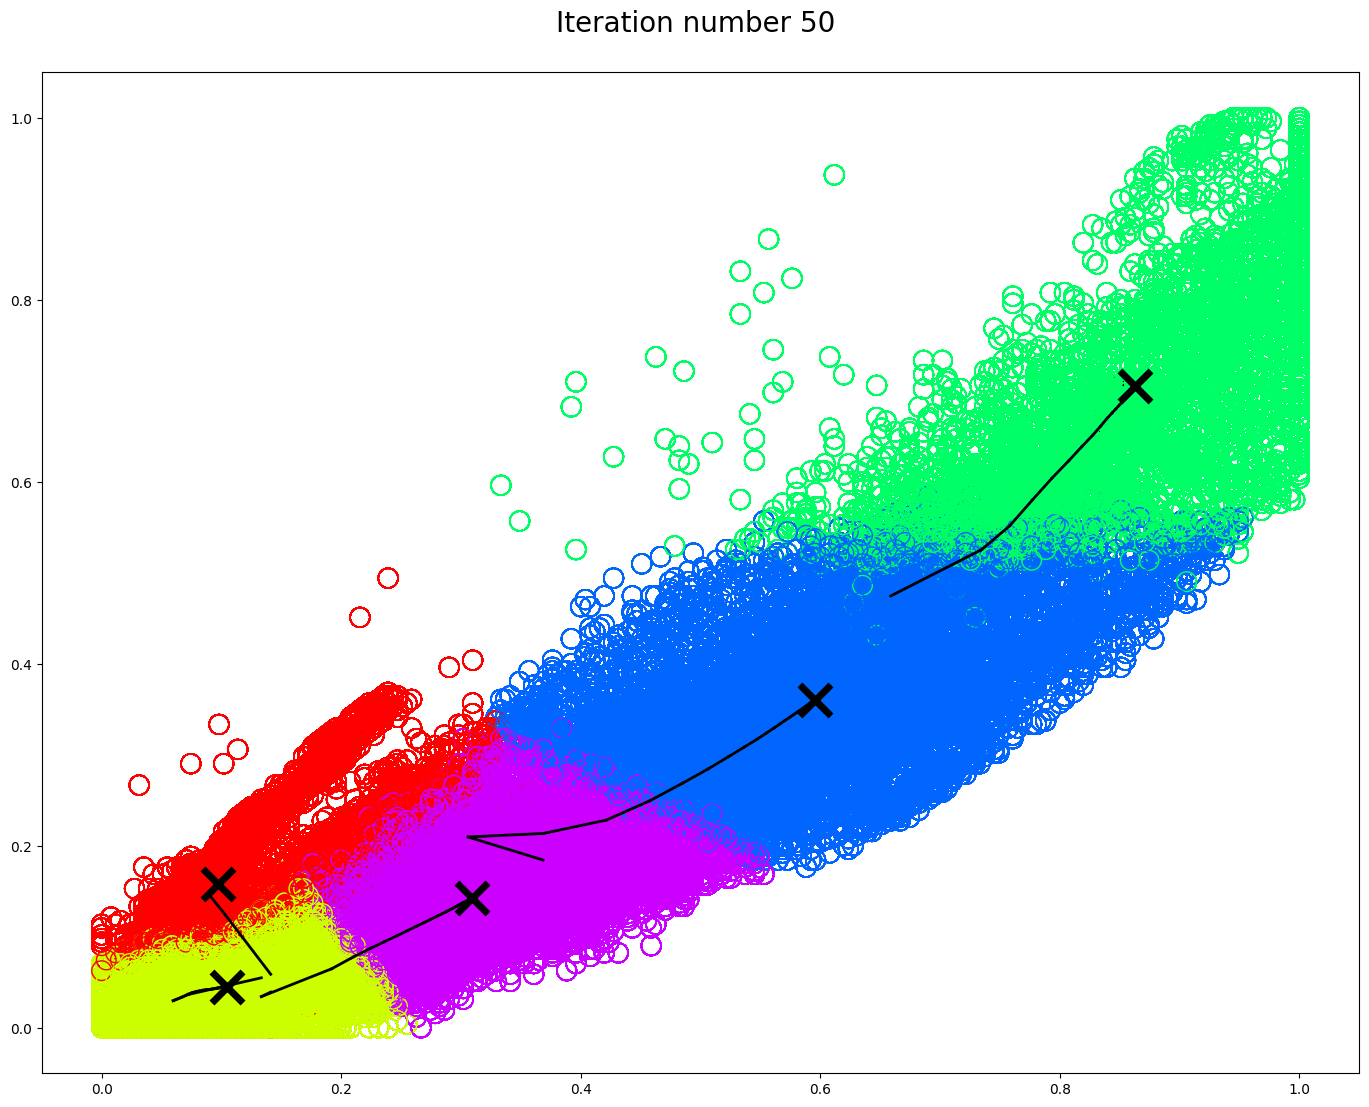

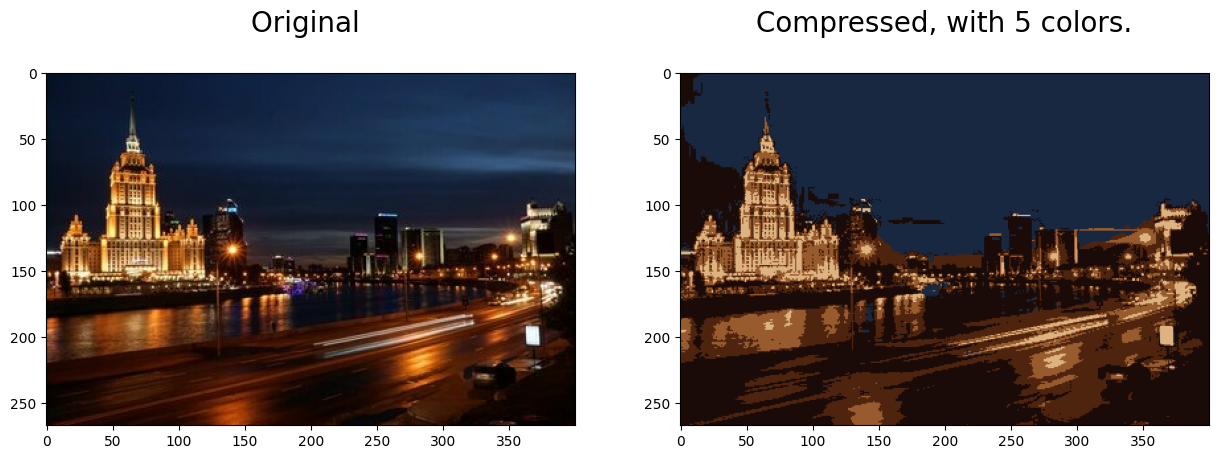

In [32]:
compress_image('moscow.mat', 5)

K-Means iteration 50/50...
Applying K-Means to compress an image.



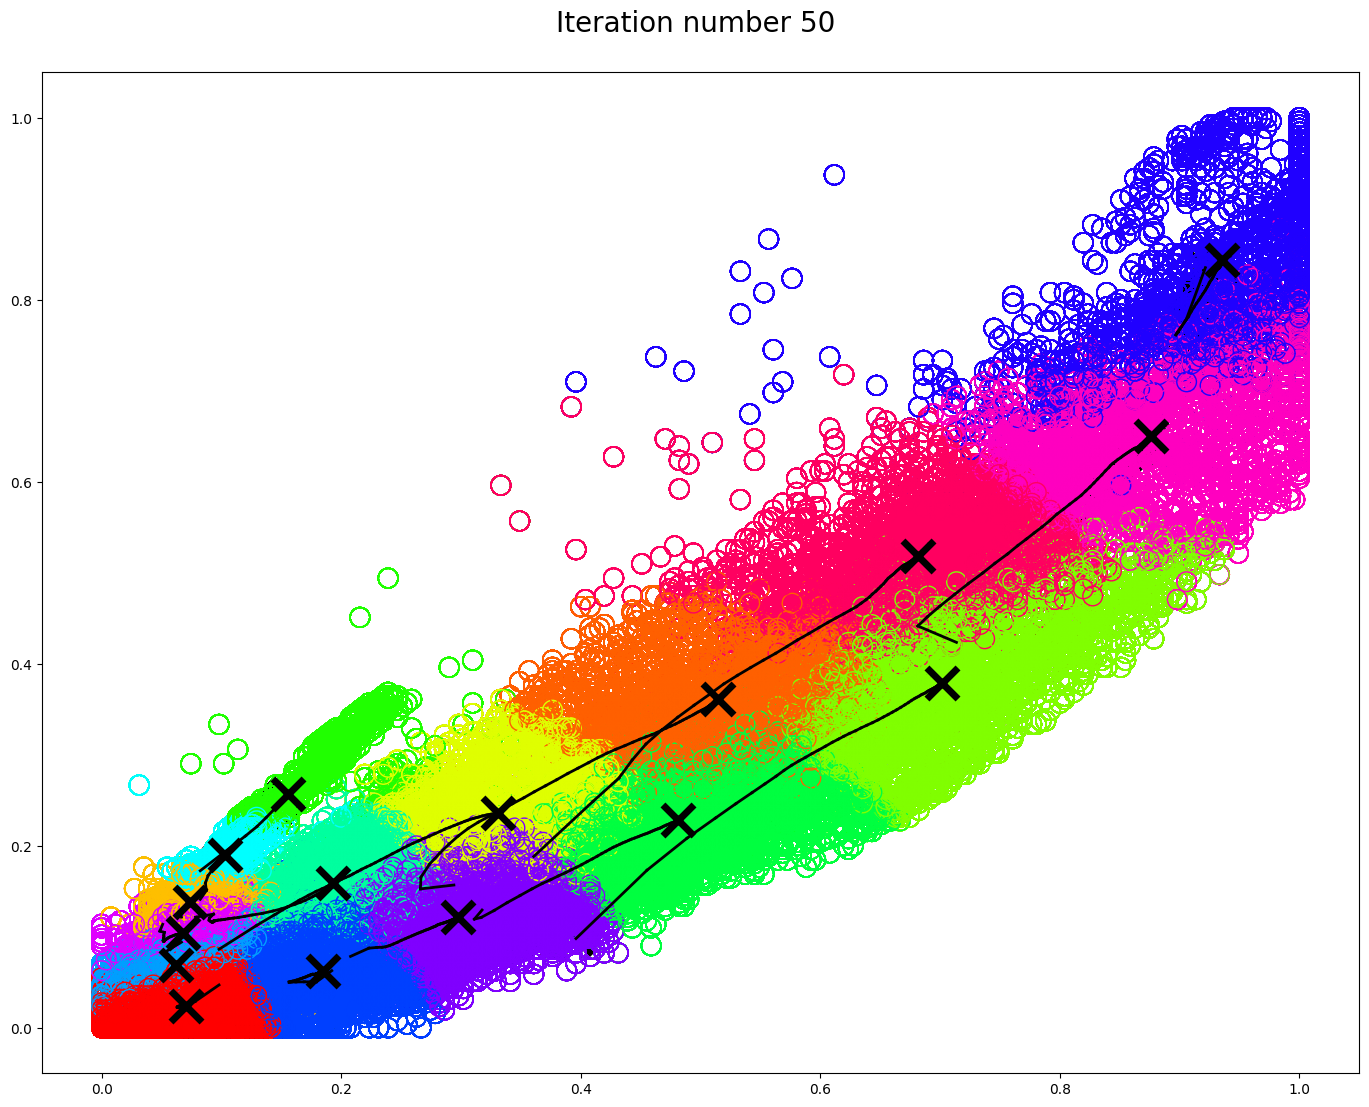

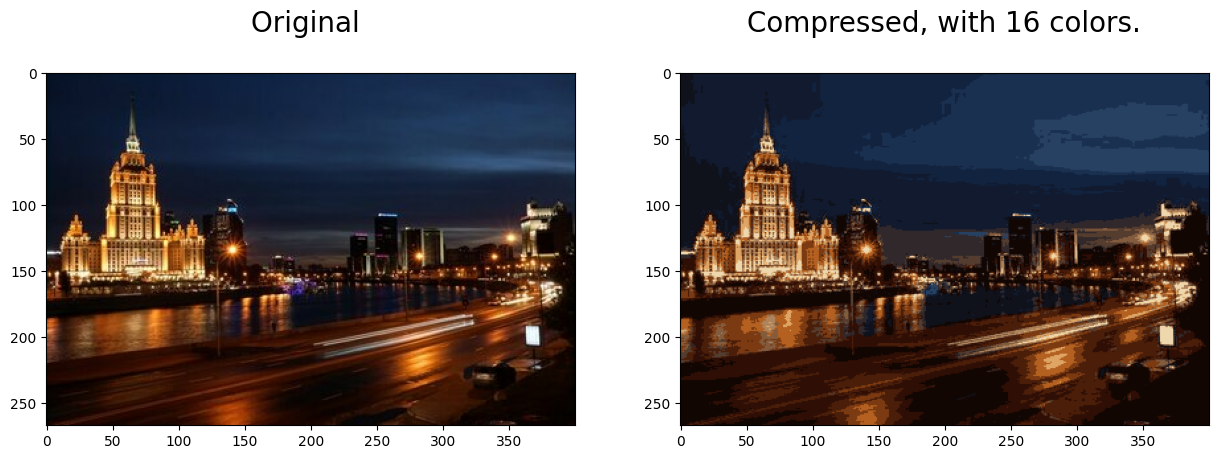

In [33]:
compress_image('moscow.mat', 16)

K-Means iteration 50/50...
Applying K-Means to compress an image.



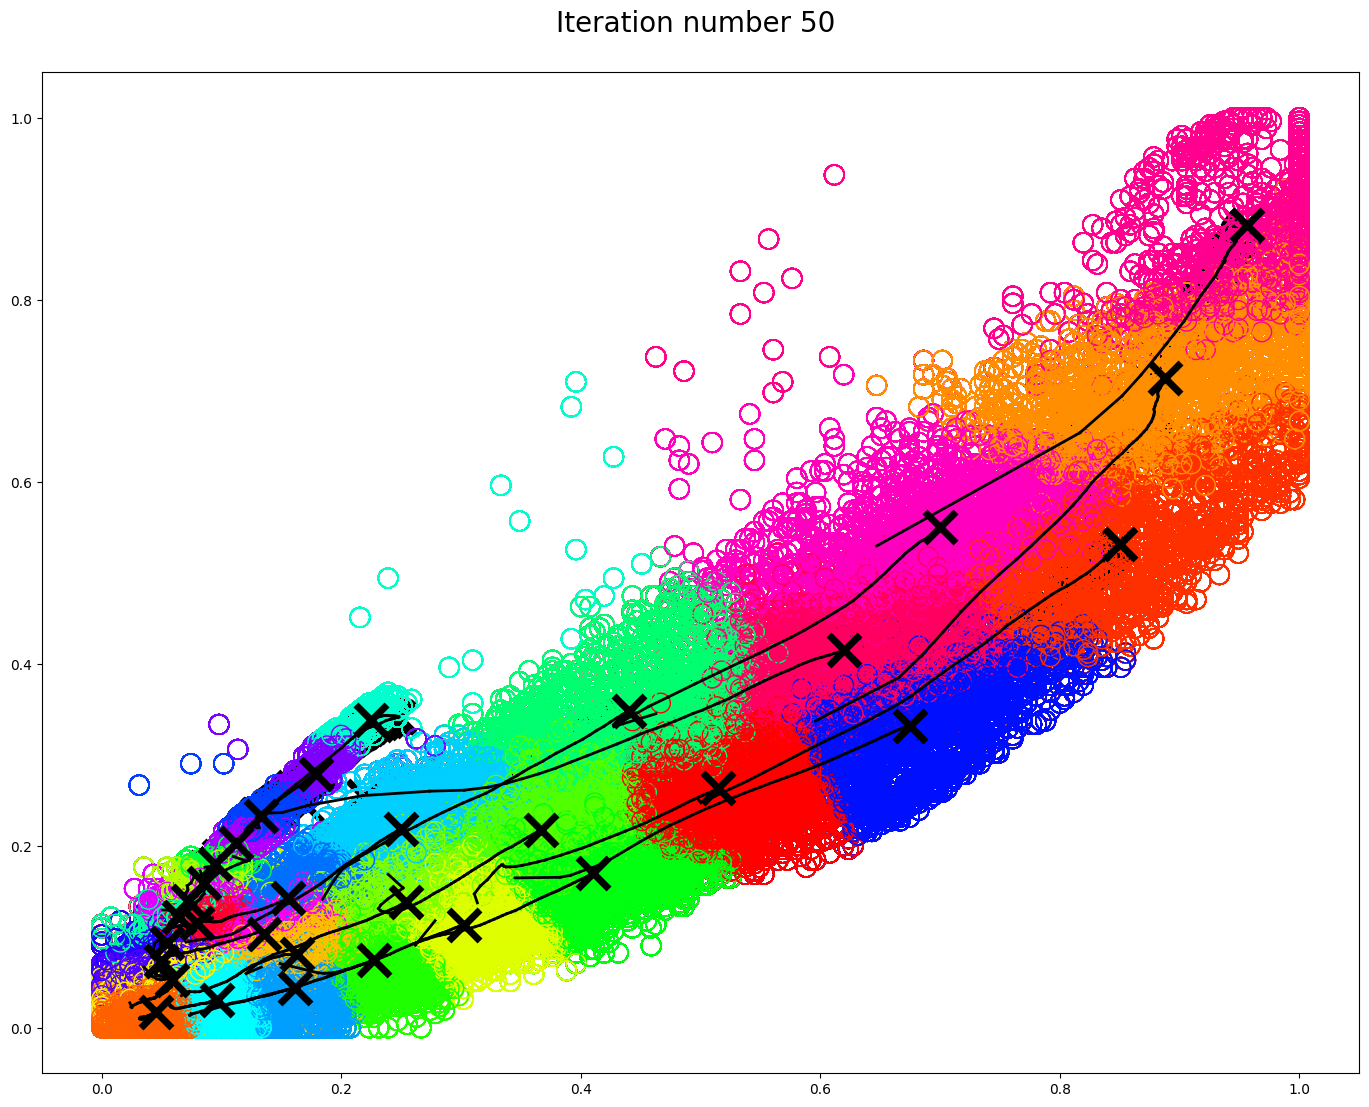

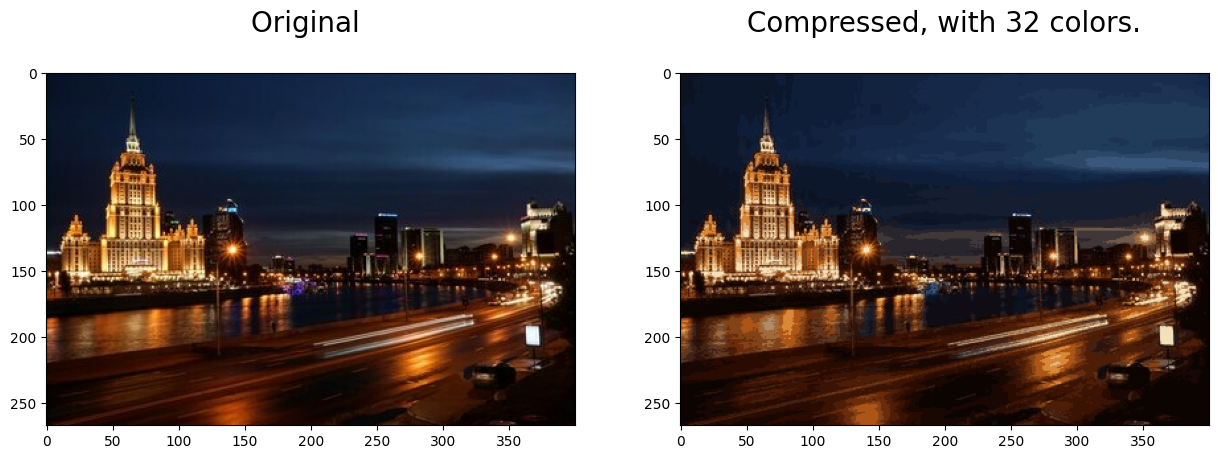

In [34]:
compress_image('moscow.mat', 32)

In [ ]:
imgg = scipy.io.loadmat('moscow.mat')
for key, value in imgg.items():
    print(f"Key: {key}, Shape: {value.shape}")

в итоге для изображения 267x400 пикселей получились следующие результаты

цвета - время  
2 - 1:48  
5 - 2:34  
16 - 5:22  
32 - 9:28  